# Gomore Dataset Analysis

### This notebook has the purposing of analysing a few aspects of the data contained in Gomore_Dataset.xlsx obtained through the data scraping script 'Gomore.py'

Firstly, the relevant modules are imported and the data within the folder is loaded as a pd.DataFrame()

A few columns are added to the dataframe and some adjustments are made for further investigation and graph aesthetics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

plt.rcParams.update({'font.size': 15})
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18



df = pd.read_excel('Gomore_Dataset.xlsx')

Occup = [int(value.replace('%','').split('.')[0]) for value in df.Occupancy]
df['Occup'] = Occup #Occupancy but in 'int' format

df['two_d'] = 0
df.loc[df.Occup>=28, 'two_d'] = 1 #True for cars that are reserved for more than 2 days
df.loc[df.Name=='Volkswagen UP!', 'Name'] = 'Volkswagen UP' #minor fix for duplicates


df['Total Price'] = df['Car Price'] + df['Service Price']
addr_n = []
for i in df['Address']:
    try:
        addr_n.append(int(i.split(' ')[0])) 
    except:
        addr_n.append(0)
df['addr_n'] = addr_n

## Price and Occupancy Analysis

The main aspects analysed in this notebook are price and occupancy. In order to get an overview of the price range of the cars listed in Gomore, a histogram is created to evaluate the number of cars in each price range and the average occupancy presented by the dataset.

It is observed that most cars fall below the 400 DKK range with popularity being well related to price.

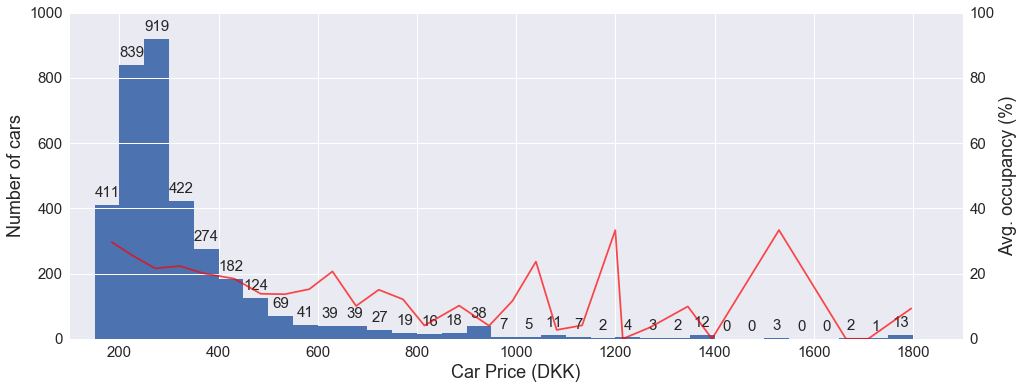

In [2]:
x = df['Car Price']
y1 = x.value_counts

intervals = range(150,1850,50)
avg_car_price = df.groupby(pd.cut(df['Car Price'], intervals)).mean()['Car Price']
avg_occ_rate = df.groupby(pd.cut(df['Car Price'], intervals)).mean()['Occup']

fig = plt.figure(figsize=(16,6))

ax1 = df['Car Price'].hist(bins = intervals);
plt.xlim(100,1900)
ax1.set_ylabel('Number of cars')
ax1.set_ylim(0,1000)
plt.xlabel('Car Price (DKK)')
for rect in ax1.patches:
    height = rect.get_height()
    ax1.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 

ax2 = ax1.twinx()
ax2.plot(avg_car_price.dropna(),avg_occ_rate.dropna(), color='r', alpha = 0.7)
ax2.set_ylabel('Avg. occupancy (%)')
ax2.set_ylim(0,100)

plt.show()

## Car Owner Analysis

Upon reading the data set, it was verified that a few owners had several cars listed. It was decided to investigate which percentage of owners use their gomore accounts with more than 3 cars listed, as shown by the pie chart and table below.

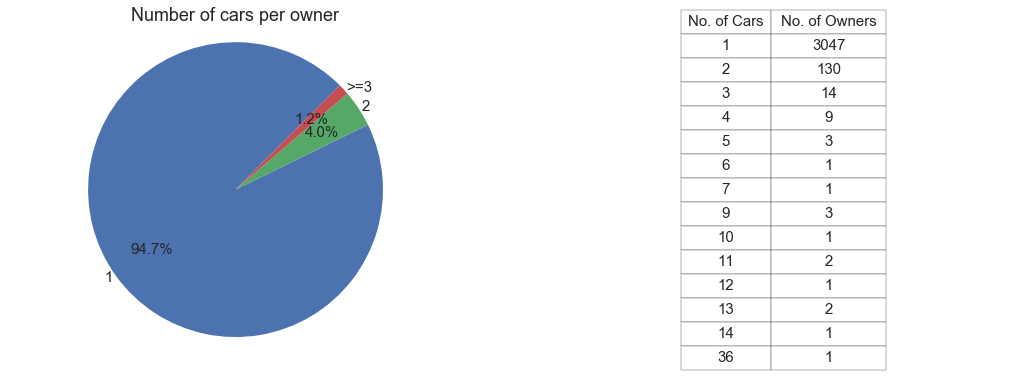

In [18]:
from collections import Counter

c = Counter(list(zip(df['Owner Name'], df['Owner ID'])))
indiv = list(c.values())

d = Counter(indiv)
labels = list(d.keys())
sizes = list(d.values())

ordered_sizes = [d[i] for i in sorted(d)]
ordered_labels = sorted(d)

n_sizes = ordered_sizes[0:2] + [sum(ordered_sizes[2:])]
n_labels = [1,2] + ['>=3']

fig = plt.figure(figsize=(18,6))

plt.subplot2grid((1,2), (0,0))
plt.pie(n_sizes, labels = n_labels, autopct='%1.1f%%', pctdistance=0.7, labeldistance=1.02, startangle=45);
plt.axis('equal');
plt.title('Number of cars per owner')

plt.subplot2grid((1,2), (0,1))
my_array = np.zeros((len(sizes),2))
my_array[:,0] = ordered_labels
my_array[:,1] = ordered_sizes
my_array = my_array.astype(int)

collabel=("No. of Cars", "No. of Owners")
the_table = plt.table(cellText=my_array,colLabels=collabel,loc='center',fontsize = 20,cellLoc='center')
the_table.auto_set_column_width(col=list(range(2)))
the_table.scale(1, 2)
plt.axis('tight')
plt.axis('off')
plt.show()

#list(c.keys())[list(c.values()).index(36)]

## Gomore "entrepreneurs"

It is observed that owners with 3 or more cars only represent 1.2% of the total owners in Gomore. Dividing such owners into 3 groups by:
* Group 1: Owners with 1 car
* Group 2: Owners with 2 cars
* Group 3: Owners with 3 or more cars

It is natural to assume that Group 3 is more invested into getting their cars busy. However, their occupancy rates are similar to those from Groups 1 and 2, as shown:

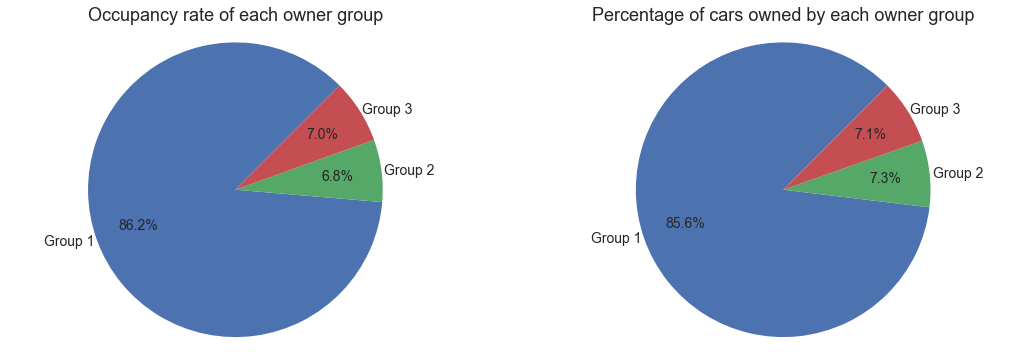

In [4]:
owner_occ =  df.groupby('Owner ID').agg(['count','sum'])['Occup']
s1 = owner_occ[owner_occ['count']==1]['sum'].sum()/df['Occup'].sum()
s2 = owner_occ[owner_occ['count']==2]['sum'].sum()/df['Occup'].sum()
s3 = owner_occ[owner_occ['count']>=3]['sum'].sum()/df['Occup'].sum()
occ_sizes = [s1,s2,s3]
occ_labels = ['Group 1','Group 2','Group 3']

fig = plt.figure(figsize=(18,6))

plt.subplot2grid((1,2), (0,0))
plt.pie(occ_sizes, labels = occ_labels, autopct='%1.1f%%', pctdistance=0.7, labeldistance=1.02, startangle=45, textprops={'fontsize': 14});
plt.axis('equal');
plt.title('Occupancy rate of each owner group')



s4 = owner_occ[owner_occ['count']==1]['count'].sum()/len(df)
s5 = owner_occ[owner_occ['count']==2]['count'].sum()/len(df)
s6 = owner_occ[owner_occ['count']>=3]['count'].sum()/len(df)
ratio_sizes = [s4, s5, s6]

plt.subplot2grid((1,2), (0,1))
plt.pie(ratio_sizes, labels = occ_labels, autopct='%1.1f%%', pctdistance=0.7, labeldistance=1.02, startangle=45, textprops={'fontsize': 14});
plt.axis('equal');
plt.title('Percentage of cars owned by each owner group')
plt.show()

# Quick Booking and Keyless

In the charts below, the efficacy of having a car listed with quick booking or keyless is evaluated. 

It appears that cars with quick booking is a better indicative of the car's likelihood to be reserved for two days or more than cars with the keyless option. 

This might be due to the quick acceptance of rentals with quick booking or higher prices found for cars with the keyless option.

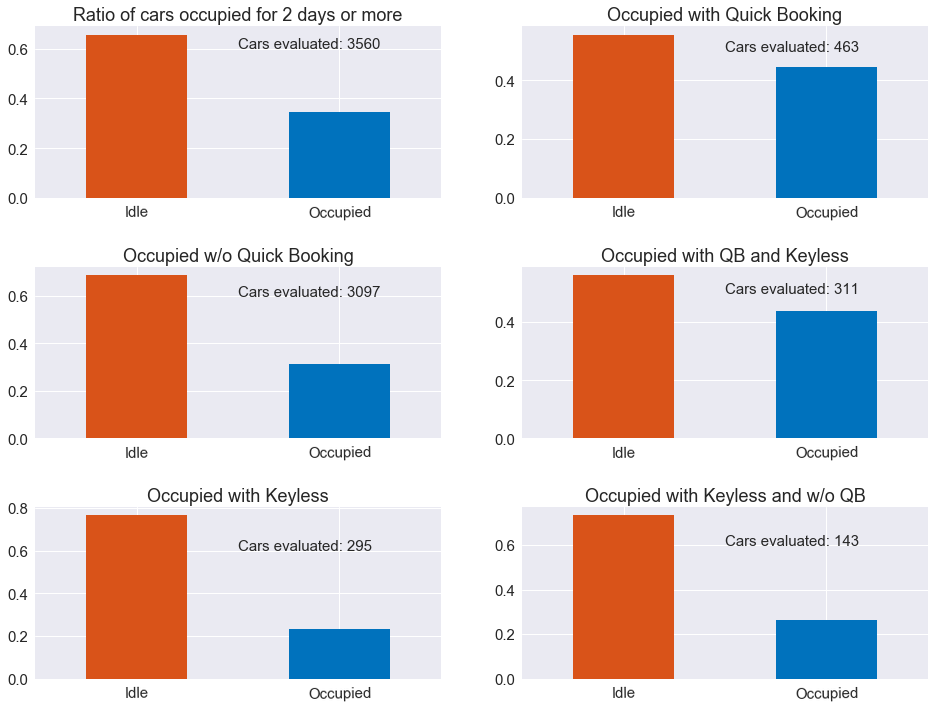

In [5]:
fig = plt.figure(figsize=(16,12))
plt.subplots_adjust(hspace = 0.4)
plt.subplot2grid((3,2),(0,0))
df.two_d.value_counts(normalize = True).plot.bar(color = [[0.8500, 0.3250, 0.0980],[0, 0.4470, 0.7410]])
loc, labels = plt.xticks()
newlabels = ['Idle','Occupied']
c1 = len(df)
plt.text(0.5,0.6,f'Cars evaluated: {c1}')
plt.xticks(loc, newlabels, rotation = True)
plt.title('Ratio of cars occupied for 2 days or more')
 
plt.subplot2grid((3,2),(0,1))
df.two_d[df['Quick Booking']== True].value_counts(normalize = True).plot.bar(color = [[0.8500, 0.3250, 0.0980],[0, 0.4470, 0.7410]])
df[df['Quick Booking']== True].groupby('Car Price').mean()
loc, labels = plt.xticks()
newlabels = ['Idle','Occupied']
c1 = len(df[df['Quick Booking']== True])
plt.text(0.5,0.5,f'Cars evaluated: {c1}')

plt.xticks(loc, newlabels, rotation = True)
plt.title('Occupied with Quick Booking')

plt.subplot2grid((3,2),(1,0))
df.two_d[df['Quick Booking']== False].value_counts(normalize = True).plot.bar(color = [[0.8500, 0.3250, 0.0980],[0, 0.4470, 0.7410]])
loc, labels = plt.xticks()
newlabels = ['Idle','Occupied']
plt.xticks(loc, newlabels, rotation = True)
c1 = len(df[df['Quick Booking']== False])
plt.text(0.5,0.6,f'Cars evaluated: {c1}')
plt.title('Occupied w/o Quick Booking')

plt.subplot2grid((3,2),(1,1))
df.two_d[(df['Keyless']== False) & (df['Quick Booking']== True)].value_counts(normalize = True).plot.bar(color = [[0.8500, 0.3250, 0.0980],[0, 0.4470, 0.7410]])
loc, labels = plt.xticks()
newlabels = ['Idle','Occupied']
plt.xticks(loc, newlabels, rotation = True)
c1 = len(df[(df['Keyless']== False) & (df['Quick Booking']== True)])
plt.text(0.5,0.5,f'Cars evaluated: {c1}')

plt.title('Occupied with QB and Keyless')

plt.subplot2grid((3,2),(2,0))
df.two_d[(df['Keyless']== True)].value_counts(normalize = True).plot.bar(color = [[0.8500, 0.3250, 0.0980],[0, 0.4470, 0.7410]])
loc, labels = plt.xticks()
newlabels = ['Idle','Occupied']
c1 = len(df[df['Keyless']== True])
plt.text(0.5,0.6,f'Cars evaluated: {c1}')

plt.xticks(loc, newlabels, rotation = True)
plt.title('Occupied with Keyless')

plt.subplot2grid((3,2),(2,1))
df.two_d[(df['Keyless']== True) & (df['Quick Booking']== False)].value_counts(normalize = True).plot.bar(color = [[0.8500, 0.3250, 0.0980],[0, 0.4470, 0.7410]])
loc, labels = plt.xticks()
newlabels = ['Idle','Occupied']
c1 = len(df[(df['Keyless']== True) & (df['Quick Booking']== False)])
plt.text(0.5,0.6,f'Cars evaluated: {c1}')

plt.xticks(loc, newlabels, rotation = True)
plt.title('Occupied with Keyless and w/o QB')


'''
plt.subplot2grid((3,3),(2,2))
df.two_d[(df['Keyless']== False) & (df['Quick Booking']== False)].value_counts(normalize = True).plot.bar(color = [[0.8500, 0.3250, 0.0980],[0, 0.4470, 0.7410]])
loc, labels = plt.xticks()
newlabels = ['Idle','Occupied']
c1 = len(df[(df['Keyless']== False) & (df['Quick Booking']== False)])
plt.text(0.5,0.6,f'Cars evaluated: {c1}')

plt.xticks(loc, newlabels, rotation = True)
plt.title('Occupied w/o both')
'''


plt.show()

# Regional Analysis

In the following charts, the disposability of cars per region is analysed in contrast with the population of the given region.

It appears that the amount of cars available is proportional to occupancy rate per region, despite the difference in population distribution (taken from dst.dk).

However, when considering the disparity between the distributions of cars and population, it is reasonable to assume that the Hovedstaden would be the most popular.

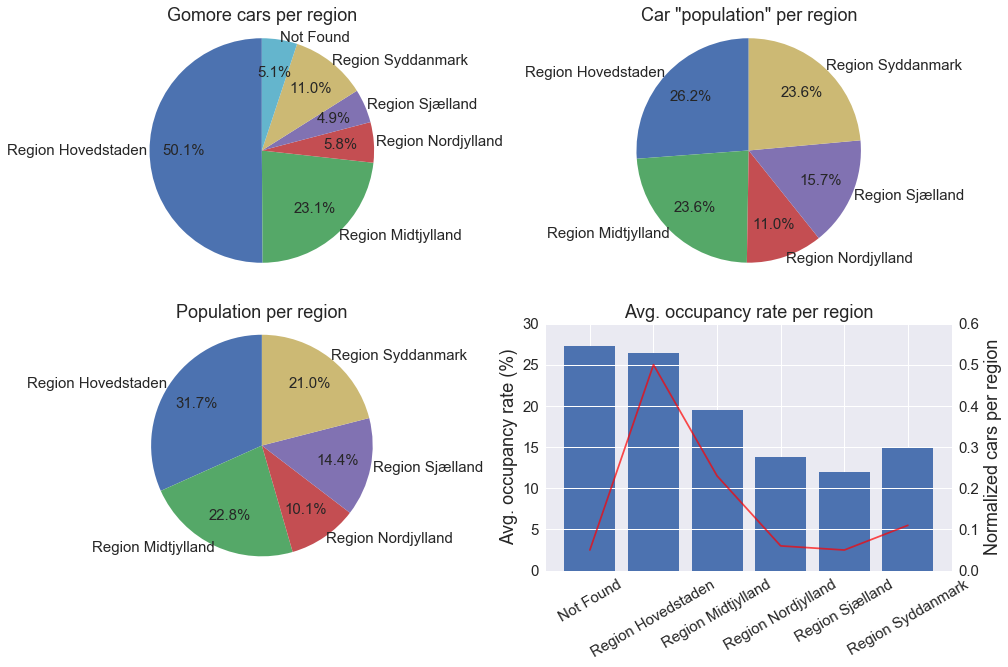

In [6]:
postnumre = pd.read_excel('postnumre.xls')

#region_list =[postnumre.loc[postnumre.POSTNR==j].ADRESSERINGSNAVN.iloc[0] for j in df.addr_n]
region_list = []

for j in df.addr_n:
    try:
        region_list.append(postnumre.loc[postnumre.POSTNR==j].ADRESSERINGSNAVN.iloc[0])
    
    except:
        region_list.append('Not Found')
        
df['Region'] = region_list
g_sizes = list(df.groupby('Region').count()['Name'])
g_sizes.append(g_sizes.pop(0))

g_labels = list(df.groupby('Region').count().index)
g_labels.append(g_labels.pop(0))        
    
fig = plt.figure(figsize=(16,10))
plt.subplot2grid((2,2),(0,0))
plt.pie(g_sizes, labels = g_labels, autopct='%1.1f%%', pctdistance=0.7, labeldistance=1.02, startangle=90);
plt.axis('equal');
plt.title('Gomore cars per region')


t_sizes = [1846000,1326000,589900,837000,1223000]
t_labels = g_labels
t_labels.remove('Not Found')

plt.subplot2grid((2,2),(1,0))
plt.pie(t_sizes, labels = t_labels, autopct='%1.1f%%', pctdistance=0.7, labeldistance=1.02, startangle=90);
plt.axis('equal');
plt.title('Population per region')


t2_sizes = [500000,450000,210000,300000,450000]

plt.subplot2grid((2,2),(0,1))
plt.pie(t2_sizes, labels = t_labels, autopct='%1.1f%%', pctdistance=0.7, labeldistance=1.02, startangle=90);
plt.axis('equal');
plt.title('Car "population" per region')


ax1 = plt.subplot2grid((2,2),(1,1))
occ_rate_reg = list(df.groupby('Region').mean()['Occup'])
occ_labels = list(df.groupby('Region').sum()['Occup'].index)
plt.bar(occ_labels, occ_rate_reg)
plt.xticks(rotation=30)
ax1.set_ylim(0,30)
ax1.set_ylabel('Avg. occupancy rate (%)')
plt.title('Avg. occupancy rate per region')

g_data = np.array([g_sizes[-1]] + g_sizes[0:-1])
graph_data = np.round(g_data/sum(g_data),2)
ax2 = ax1.twinx()
ax2.plot(occ_labels, graph_data, color='r', alpha = 0.7)
ax2.set_ylabel('Normalized cars per region')
ax2.set_ylim(0,0.6)


plt.show()

In [7]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

# Gomore Champions

Analysing cars with at least 10 duplicates, a ranking is created below with the associated occupancy.

The table on the side informs the amount of duplicates and average price combining the car's price and service price.

Most cars are below the 400 DKK threshold with the notable exception of the Tesla Model 3.

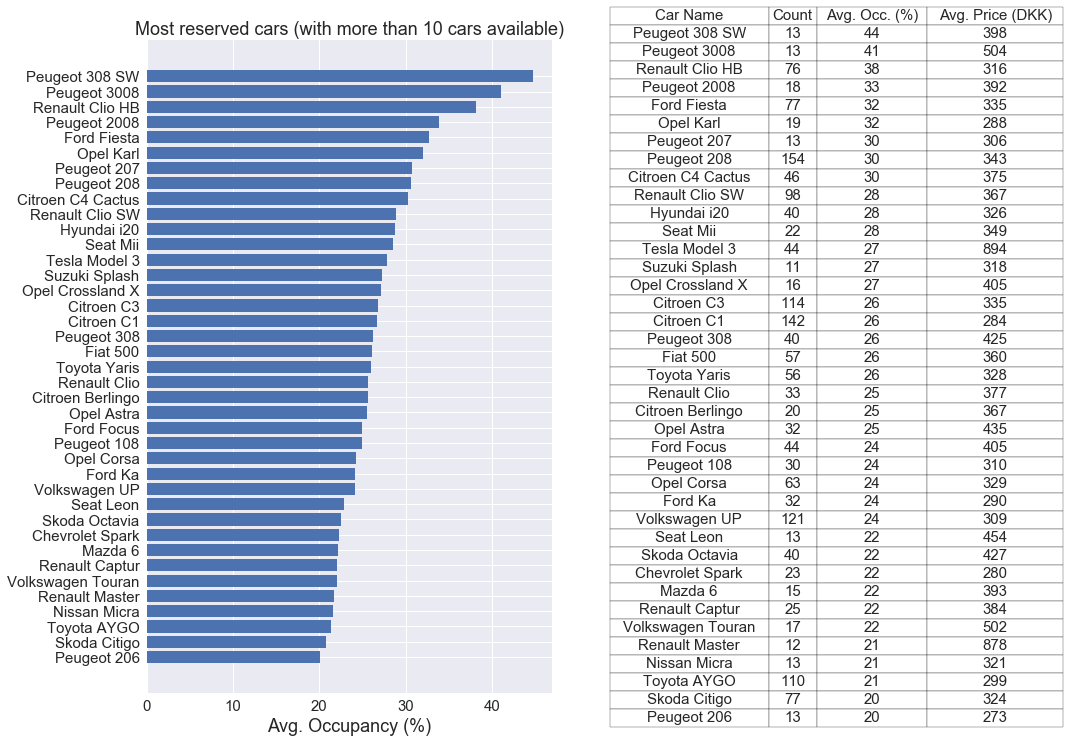

In [17]:
count_sum = df.groupby('Name')['Occup'].agg(['count','mean']).sort_values('mean',ascending = False)
fig = plt.figure(figsize= (16,12))
plt.subplot2grid((1,2),(0,0))
most_wanted = count_sum[(count_sum['count'] > 10) & (count_sum['mean'] >= 20)]
ax = plt.barh(most_wanted.index,most_wanted['mean'])
#plt.ticks(rotation = 90)
plt.title('Most reserved cars (with more than 10 cars available)')
plt.xlabel('Avg. Occupancy (%)')
plt.gca().invert_yaxis()

plt.subplot2grid((1,2),(0,1))

avg_list = df[df.Name.isin(list(most_wanted.index))].groupby('Name').mean()
avg_prices = avg_list.loc[list(most_wanted.index)]['Car Price'] + avg_list.loc[list(most_wanted.index)]['Service Price'] 

collabel=("Car Name", "Count","Avg. Occ. (%)","Avg. Price (DKK)")
my_array = np.c_[most_wanted.index, most_wanted.to_numpy().astype(int),avg_prices.to_numpy().astype(int)]
the_table = plt.table(cellText=my_array,colLabels=collabel,loc='center',fontsize = 20,cellLoc='center')

the_table.auto_set_column_width(col=list(range(4)))
the_table.scale(1, 1.5)

plt.axis('tight')
plt.axis('off')


plt.show()

# Possible correlations

Lastly, the cars' occupancy is analysed with regards to the car's year, owner's response time and car type.

Cars manufactured more recently have a higher chance of being occupied and the owner's response time does not have too much correlation to the car's occupancy if it is within one hour

The most popular car type are autocampers but it is a relatively small group followed by the large "city car" group. Likely related to the low price offered in this category.

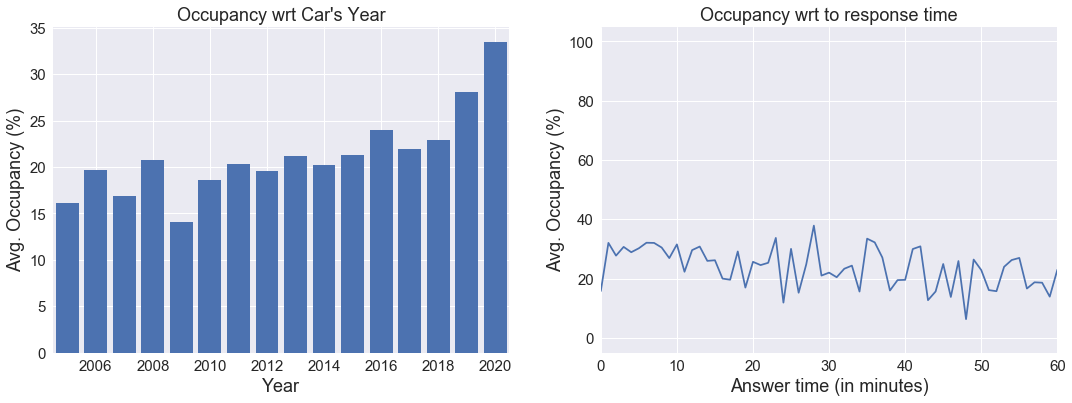

In [9]:
fig = plt.figure(figsize=(18,6))

plt.subplot2grid((1,2),(0,0))
plt.bar(range(2005,2021),df.groupby('Year').mean()['Occup'])
plt.xlim(2004.5,2020.5)
plt.xlabel('Year')
plt.ylabel('Avg. Occupancy (%)')
plt.title("Occupancy wrt Car's Year")


plt.subplot2grid((1,2),(0,1))
ans_time = []
for i in df['Answer Time']:
    j = i.split(' ')[-2]
    if j =='':
        j= 0
    else:
        j = int(j)
    
    if 'dag' in i:
        ans_time.append(j*1440)
    elif 'time' in i:
        ans_time.append(j*60)
    elif 'uge' in i:
        ans_time.append(j*1440*7)
    else:
        ans_time.append(j)
df['ans_time'] = ans_time
mean_at = df.groupby('ans_time').mean().Occup
plt.plot(mean_at.index, mean_at)
plt.xlabel('Answer time (in minutes)')
plt.ylabel('Avg. Occupancy (%)')
plt.title('Occupancy wrt to response time')
plt.xlim(0,60)
plt.show()

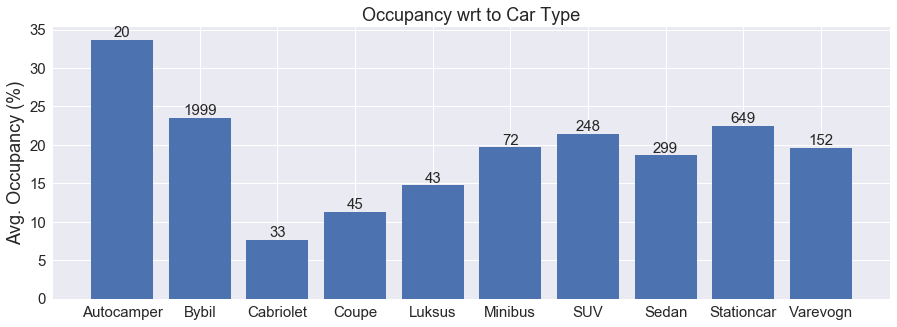

In [10]:
fig = plt.figure(figsize=(15,5))
df.loc[df.Type == 'Type', 'Type'] ='Bybil'
mean_ct = df.groupby('Type').mean().Occup
ax = plt.bar(mean_ct.index, mean_ct)
plt.ylabel('Avg. Occupancy (%)')
plt.title('Occupancy wrt to Car Type')

names = list(df.groupby('Type').count()['Name'])
for i, rect in enumerate(ax.patches):
    height = rect.get_height()
    plt.text((rect.get_x()+rect.get_width()/2),height,f'{names[i]}', ha='center', va='bottom') 

plt.show()